In [1]:
import sys
from PCA import PCA
from IsolationForest import IsolationForest
from preprocessing import FeatureExtractor
import fasttext
from tokenizer import my_tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ft = fasttext.load_model("fasttext_model/mix.bin")

old_test = "input/k3s_test_pred.csv"
old_train = "input/k3s_train_pred.csv"
new_test = "input/newk3s1-test.csv" #"input/merged_predictions.csv"
new_train = "input/newk3s1-train.csv"

## load oldk3s or newk3s dataset
file_train = new_train
file_test = new_test

window_size = 5 #  timewindow size

df_train = pd.read_csv(file_train, parse_dates=True)
df_test = pd.read_csv(file_test, parse_dates=True)

from drain3 import TemplateMiner
persistence_type =None
tm = TemplateMiner(persistence_type)

def train_drain(train_data):
    for line in train_data:
        msg = line.lower().rstrip()
        tokens = my_tokenize(msg)
        msg = " ".join(tokens)
        tm.add_log_message(msg)
        
## for drain template training
train_drain(df_train["message"])

def get_train_test():
    
    print('Loading phase:')
    train_vecs = load_data(train_file)
    test_vecs = load_data(test_file)
    return train_vecs, test_vecs

def l2_norm(x):
   return np.sqrt(np.sum(x**2))
def div_norm(x):
   norm_value = l2_norm(x)
   if norm_value > 0:
       return x * ( 1.0 / norm_value)
   else:
       return x
def get_sentence_vector(tokens):
    wordvecs_split = [ft[word] for word in tokens]
    processed_word_vectors = []
    for word_vector in wordvecs_split:
        processed_word_vectors.append(div_norm(word_vector))
    processed_word_vectors = np.array(processed_word_vectors)
    return np.mean(processed_word_vectors,axis=0)

def match_template_vector(tokens):
    msg = " ".join(tokens)
    res = tm.drain.tree_search(tm.drain.root_node ,tokens)
    vec = [0] * (tm.drain.clusters_counter + 1)
    tid = res.cluster_id - 1 if res is not None else tm.drain.clusters_counter
    vec[tid] += 1
    return np.array(vec)


config file not found: drain3.ini


In [2]:
## preprocess data, get vectors and group them into time-windows

def preprocess_data(input_df):
    df = input_df
    real_ts = ["2020 " + " ".join(rl.split()[:3]) for rl in df["raw_line"]]
    df["real_ts"] = real_ts
    from datetime import datetime
    new_ts = pd.to_datetime(df["real_ts"])
    df["real_ts"] = [int(datetime.timestamp(x)) for x in new_ts]
    
    from collections import defaultdict
    data_dict = defaultdict(list)
    for idx, line in enumerate(df["message"]):
        ts = (df["real_ts"][idx] // window_size) * window_size ## group to same timewindow
        msg = line.lower().rstrip()
        tokens = my_tokenize(msg)
        
        ## choose fasttext embedding or drain templates
        vec = get_sentence_vector(tokens) ## sentence embeddings
        #vec = match_template_vector(tokens) ## drain templates
        
        data_dict[ts].append(vec)
    
    return data_dict

train_dict = preprocess_data(df_train)
test_dict = preprocess_data(df_test)

def form_windows(data_dict):
    ts_list = []
    data_list = []
    for ts in data_dict.keys():
        lists = data_dict[ts]
        sums = np.sum(lists,axis=0) # mean or sum
        data_list.append(sums)
        ts_list.append(ts)
    return np.array(data_list), ts_list
    
train_vecs, train_ts = form_windows(train_dict)
test_vecs, test_ts = form_windows(test_dict)



In [3]:
def train_pca(train_vecs, test_vecs):
    print('Train phase:')
    feature_extractor = FeatureExtractor()
    x_train = feature_extractor.fit_transform(train_vecs, normalization='zero-mean')
    #x_train = train_vecs
    model = PCA() 
    model.fit(x_train)
    y_train = model.predict(x_train)
    print('Test phase:')
    x_test = feature_extractor.transform(test_vecs) 

    y_test = model.predict(x_test)
    return y_train, y_test

def train_iforest(train_vecs, test_vecs):
    print('Train phase:')
    feature_extractor = FeatureExtractor()
    x_train = feature_extractor.fit_transform(train_vecs)
    x_test = feature_extractor.transform(test_vecs)

    #model = ensemble.IsolationForest(contamination=anomaly_ratio)
    model = IsolationForest()
    model.fit(x_train)

    y_train = model.predict(x_train)

    y_test = model.predict(x_test)
    return y_train, y_test

## train pca and iforest here

y_train_pca, y_test_pca = train_pca(train_vecs, test_vecs)
y_train_if, y_test_if = train_iforest(train_vecs, test_vecs)

Train phase:
Train data shape: 74017-by-100

====== Model summary ======
n_components: 2
Project matrix shape: 100-by-100
SPE threshold: 10.190012320115283

Test phase:
Test data shape: 43285-by-100

Train phase:
Train data shape: 74017-by-100

Test data shape: 43285-by-100

====== Model summary ======


/Users/tybalex/.pyenv/versions/3.6.8/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


In [4]:
## create the dataframe and visualize the results

def create_df(_ts):
    _df = pd.DataFrame({"timestamp" : _ts})
    _df["date_time"] = pd.to_datetime(_df["timestamp"], unit="s")
    _df.set_index("date_time",inplace=True)
    return _df
train_df = create_df(train_ts)
test_df = create_df(test_ts)

train_df["windowed_pca_anomaly"] = y_train_pca
test_df["windowed_pca_anomaly"] = y_test_pca

train_df["windowed_iforest_anomaly"] = y_train_if
test_df["windowed_iforest_anomaly"] = y_test_if

/Users/tybalex/.pyenv/versions/3.6.8/envs/py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'windowed_iforest_anomaly')

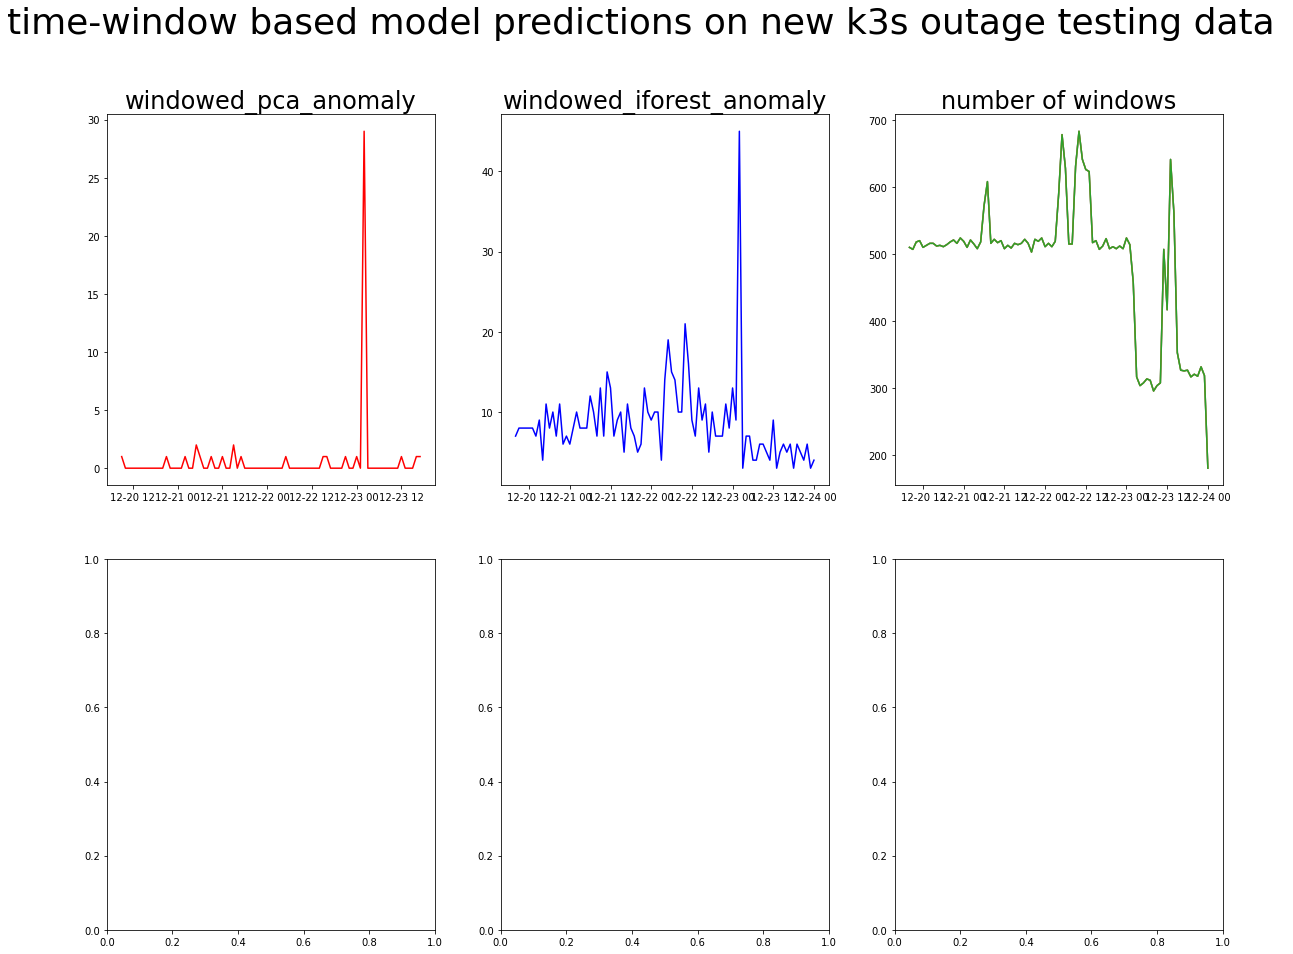

In [5]:
df = test_df
import matplotlib.pyplot as plt
fig, axe = plt.subplots(nrows=2, ncols=3,figsize=(20, 15))
fig.suptitle("time-window based model predictions on new k3s outage testing data ", fontsize= 36)

timescale = "1H"

axe[0,2].plot(df.resample(timescale).count())
axe[0,2].set_title("number of windows", fontsize=24)

fields = "windowed_pca_anomaly"
df1 = df[df[fields]==1]
#df1.resample(timescale).count()[fields].plot(color="Red")
p1 = df1.resample(timescale).count()[fields]
axe[0, 0].plot(p1, color="Red")
axe[0, 0].set_title(fields, fontsize=24)

fields2 = "windowed_iforest_anomaly"
df2 = df[df[fields2]==1]
#df1.resample(timescale).count()[fields].plot(color="Red")
p2 = df2.resample(timescale).count()[fields2]
axe[0, 1].plot(p2, color="Blue")
axe[0, 1].set_title(fields2, fontsize=24)